In [1]:
# add src to the sys path of this notebook
import sys
import pathlib
sys.path.append(str(pathlib.Path().absolute().parent / "src"))

from data.load_data import load_data, list_logs, load_labels, load_and_preprocess
import data.load_data as ld
from data.preprocess_data import preprocess_logs_old, get_label_timeseries, downsample, filter
from models.helpers import create_model_params
import data.paths as config
import numpy as np
import os
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

# Load Data

In [3]:
heads_keep = ["timestamp [s]", "Force sensor voltage [V]", "Camera trigger signal"]
heads_rename = ["timestamps", "force_sensor_v", "camera_trigger_signal"]
f_s = 1000
fss = 568.5
log_names = list_logs(config.PAPER_EXPERIMENT_DATA_FOLDER)
log_names.reset_index(drop=True, inplace=True)
logs = load_data(log_names, heads_keep, heads_rename, fss)
print(f"Loaded {len(logs)} logs from paper experiments.")

Listing all logs withtout specific configuration filtering.
Loaded 208 logs from paper experiments.


In [4]:
log_names.head()

,path,path_markers,datetime,clot_index,direction,model,placement,wire_shape,technique,clot_presence,stiffness,pressure
0,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:38:36,1,Forward,Conical,Conical Placement,Straight,No_Twist,With,NaN,NaN
1,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:40:03,1,Backward,Conical,Conical Placement,Straight,No_Twist,With,NaN,NaN
2,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:53:54,2,Forward,Conical,Conical Placement,Straight,No_Twist,With,NaN,NaN
3,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:55:28,2,Backward,Conical,Conical Placement,Straight,No_Twist,With,NaN,NaN
4,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 16:04:04,3,Forward,Conical,Conical Placement,Straight,No_Twist,With,NaN,NaN


# Camera Trigger signal

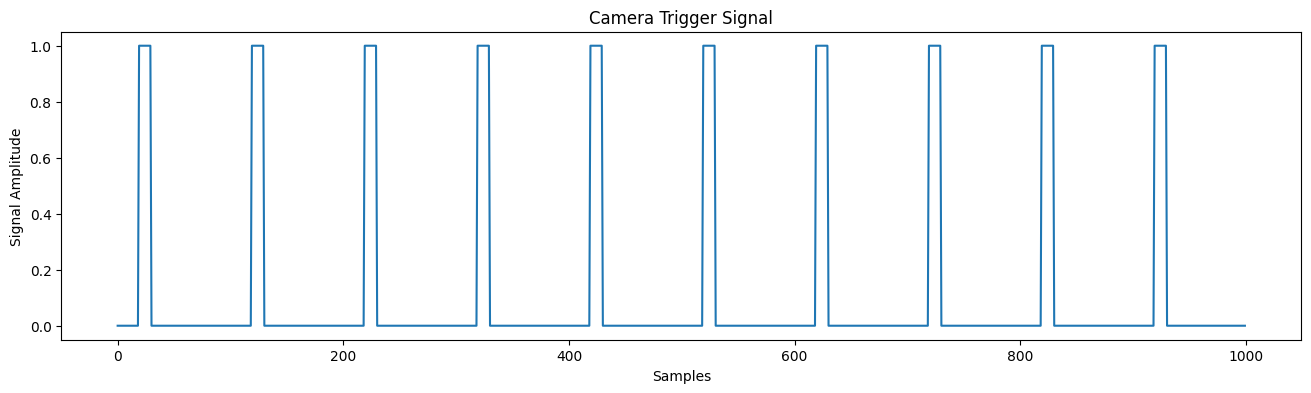

In [5]:
data = logs[0]['camera_trigger_signal'].values
plt.figure(figsize=(16, 4))
plt.plot(data[:1000])
plt.title("Camera Trigger Signal")
plt.xlabel("Samples")
plt.ylabel("Signal Amplitude")
plt.show()

We clearly see here that the camera is taking pictures at 10 Hz

Let's transform it into something we can better use

In [6]:
# the array is a sequence of 00111110000001111 patterns indicating the camera trigger events I want to retrieve the timestamps of the start of the trigger so change from 0 to 1
trigger_indices = np.where((data[:-1] == 0) & (data[1:] == 1))[0] + 1  # +1 to get the index of the '1' value
trigger_times = logs[0]['timestamps'].values[trigger_indices]
print(f"Found {len(trigger_times)} trigger events out of {len(data)} samples.")
print(trigger_times[:10])

Found 365 trigger events out of 36437 samples.
[0.019 0.119 0.219 0.319 0.419 0.519 0.619 0.719 0.819 0.919]


# Clot Detection

Calibration Image Camera 1 shape: (1154, 984, 3)
Calibration Image Camera 2 shape: (942, 1272, 3)
Downsampled Calibration Image Camera 1 shape: (246, 288, 3)
Downsampled Calibration Image Camera 2 shape: (236, 318, 3)


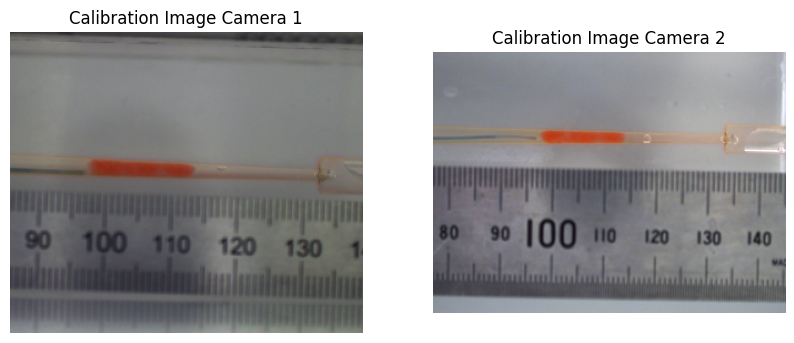

In [7]:
log = log_names.loc[0]
from pathlib import Path
import cv2
import numpy as np
import torch

folder = Path(log["path"]).parent

# --- Load calibration images RGB ---
calib1_rgb = cv2.imread(str(folder / "calibration_image.jpg"), cv2.IMREAD_COLOR).astype(np.float32) / 255.0
calib2_rgb = cv2.imread(str(folder / "calibration_imageII.jpg"), cv2.IMREAD_COLOR).astype(np.float32) / 255.0
# print shapes
print(f"Calibration Image Camera 1 shape: {calib1_rgb.shape}")
print(f"Calibration Image Camera 2 shape: {calib2_rgb.shape}")
# downsaple calibration images for faster processing
calib1_rgb = cv2.resize(calib1_rgb, (0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
# turn calib1 img to the right orientation
calib1_rgb = cv2.rotate(calib1_rgb, cv2.ROTATE_90_CLOCKWISE)
calib2_rgb = cv2.resize(calib2_rgb, (0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
calib2_rgb = cv2.rotate(calib2_rgb, cv2.ROTATE_90_CLOCKWISE)
calib2_rgb = cv2.rotate(calib2_rgb, cv2.ROTATE_90_CLOCKWISE)
print(f"Downsampled Calibration Image Camera 1 shape: {calib1_rgb.shape}")
print(f"Downsampled Calibration Image Camera 2 shape: {calib2_rgb.shape}")
# plot calibration images
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Calibration Image Camera 1")
# show the images with matplotlib
plt.imshow(calib1_rgb[...,::-1])  # Convert BGR to RGB
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Calibration Image Camera 2")
plt.imshow(calib2_rgb[...,::-1])  # Convert BGR to RGB
plt.axis('off')
plt.show()

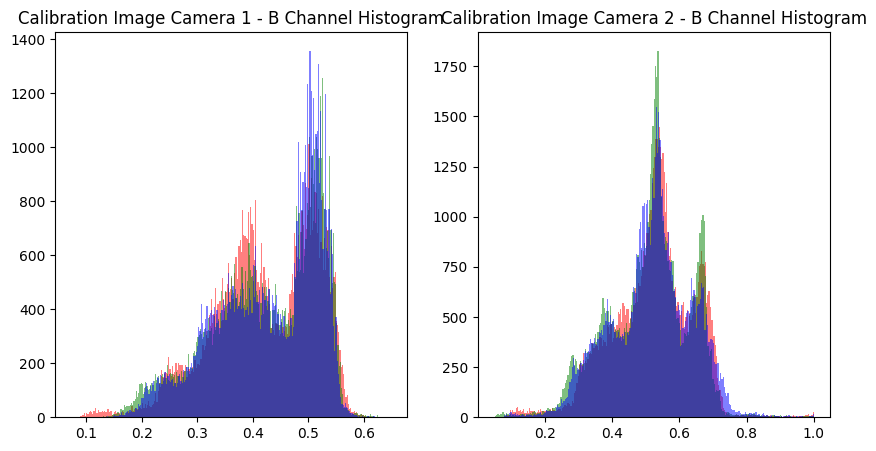

In [8]:
# plot histograms of each channel
colors = ('r','g','b')
plt.figure(figsize=(10,5))
for i, color in enumerate(colors):
    plt.subplot(1,2,1)
    plt.title(f"Calibration Image Camera 1 - {color.upper()} Channel Histogram")
    plt.hist(calib1_rgb[...,i].ravel(), bins=256, color=color, alpha=0.5)
    plt.subplot(1,2,2)
    plt.title(f"Calibration Image Camera 2 - {color.upper()} Channel Histogram")
    plt.hist(calib2_rgb[...,i].ravel(), bins=256, color=color, alpha=0.5)
plt.show()

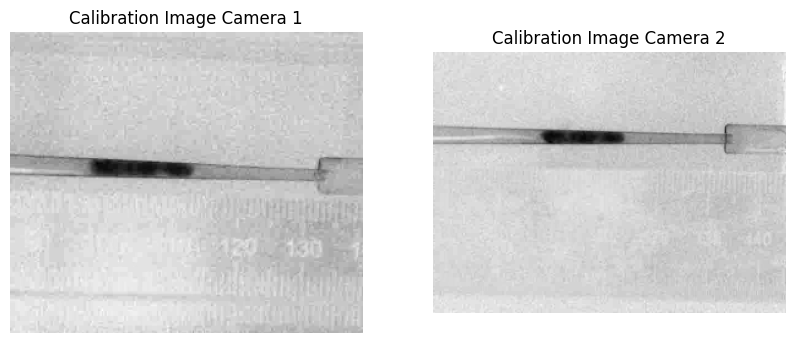

In [9]:
# plot red channel calibration images
calib1_red = calib1_rgb[...,0] - calib1_rgb[...,1]*0.5 - calib1_rgb[...,2]*0.5
calib2_red = calib2_rgb[...,0] - calib2_rgb[...,1]*0.5 - calib2_rgb[...,2]*0.5
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Calibration Image Camera 1")
# show the images
plt.imshow(calib1_red, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Calibration Image Camera 2")
plt.imshow(calib2_red, cmap='gray')
plt.axis('off')
plt.show()

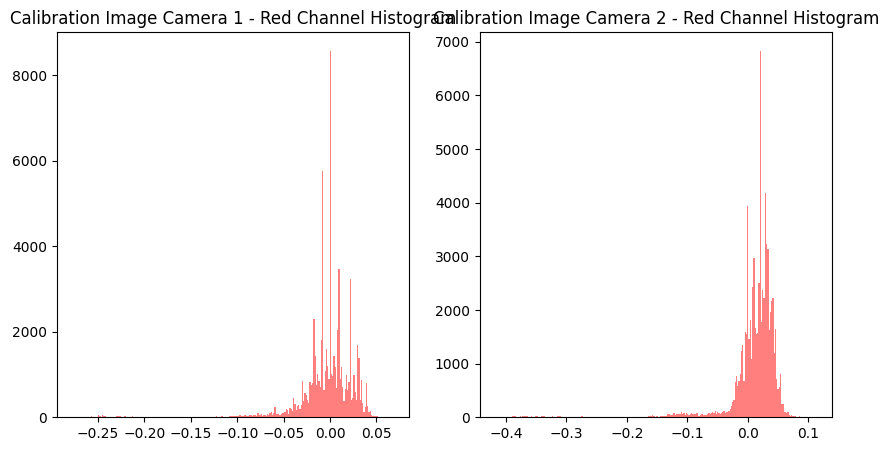

In [10]:
# print histograms of red channel
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Calibration Image Camera 1 - Red Channel Histogram")
plt.hist(calib1_red.ravel(), bins=256, color='r', alpha=0.5)
plt.subplot(1,2,2)
plt.title("Calibration Image Camera 2 - Red Channel Histogram")
plt.hist(calib2_red.ravel(), bins=256, color='r', alpha=0.5)
plt.show()

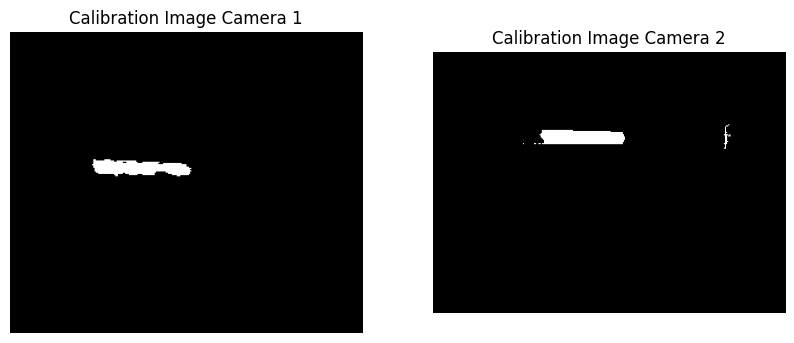

In [11]:
# make binary under thresholding
threshold = -0.2
calib1 = (calib1_red < threshold).astype(np.float32)
calib2 = (calib2_red < threshold).astype(np.float32)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Calibration Image Camera 1")
# show the images
plt.imshow(calib1, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Calibration Image Camera 2")
plt.imshow(calib2, cmap='gray')
plt.axis('off')
plt.show()

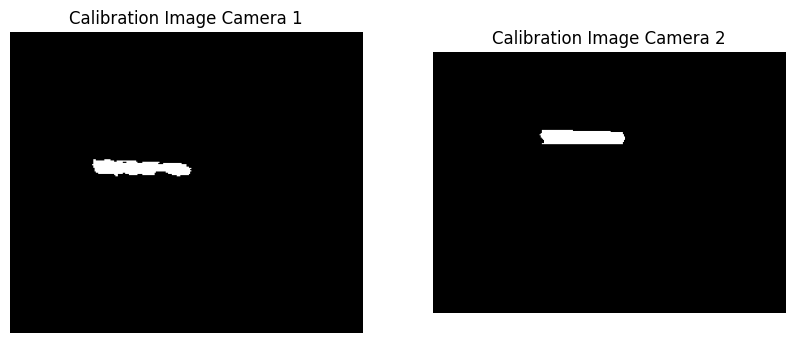

In [12]:
# keep only main blob 
import scipy.ndimage as ndi
labeled_array1, num_features1 = ndi.label(calib1)
sizes1 = ndi.sum(calib1, labeled_array1, range(num_features1 + 1))
largest_label1 = np.argmax(sizes1[1:]) + 1  # +1 because sizes1[0] is the background
calib1 = (labeled_array1 == largest_label1).astype(np.float32)
labeled_array2, num_features2 = ndi.label(calib2)
sizes2 = ndi.sum(calib2, labeled_array2, range(num_features2 + 1))
largest_label2 = np.argmax(sizes2[1:]) + 1  # +1 because sizes2[0] is the background
calib2 = (labeled_array2 == largest_label2).astype(np.float32)
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Calibration Image Camera 1")
# show the images
plt.imshow(calib1, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Calibration Image Camera 2")
plt.imshow(calib2, cmap='gray')
plt.axis('off')
plt.show()

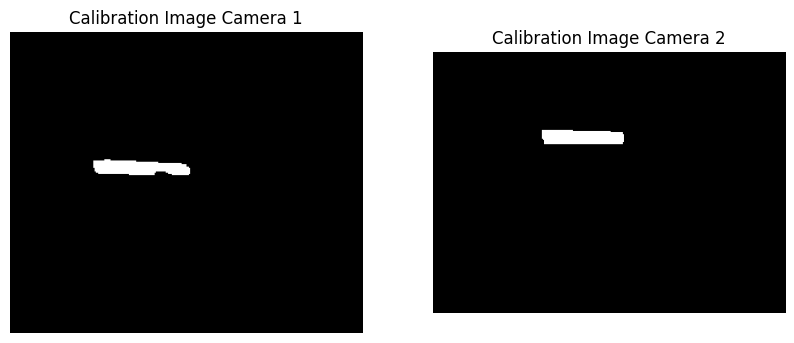

calib image unique values cam 1: [0. 1.]
calib image unique values cam 2: [0. 1.]


In [13]:
# smooth shape of blob with binary opening
structure = np.ones((5,5))
calib1_opened = ndi.binary_opening(calib1, structure=structure).astype(np.float32)
calib2_opened = ndi.binary_opening(calib2, structure=structure).astype(np.float32)
calib1_smoothed = ndi.binary_closing(calib1_opened, structure=structure).astype(np.float32)
calib2_smoothed = ndi.binary_closing(calib2_opened, structure=structure).astype(np.float32)
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Calibration Image Camera 1")
# show the images
plt.imshow(calib1_smoothed, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Calibration Image Camera 2")
plt.imshow(calib2_smoothed, cmap='gray')
plt.axis('off')
plt.show()
print(f"calib image unique values cam 1: {np.unique(calib1_smoothed)}")
print(f"calib image unique values cam 2: {np.unique(calib2_smoothed)}")

# Wire detection

## Background

In [14]:
from utils.extract_number import extract_number


# --- Load frame lists ---
cam1_paths = sorted(folder.glob("frameID_*.jpg"), key=extract_number)
cam2_paths = sorted(folder.glob("II_frameID_*.jpg"), key=extract_number)

### check id extract


In [15]:
path = cam2_paths[110]
from data.preprocess_data import get_frame_id_from_path
frame_id = get_frame_id_from_path(path)
print(frame_id)

IndexError: list index out of range

## Absolute diff with first image

In [ ]:
background_1 = cv2.resize(cv2.imread(cam1_paths[0], cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0, (0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
background_2 = cv2.resize(cv2.imread(cam2_paths[0], cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0, (0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)

# Preallocate arrays
cam1_imgs = np.stack([
    cv2.absdiff(cv2.resize(cv2.imread(str(p), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0, (0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA), background_1)
    for p in cam1_paths
]).astype(np.float32)

cam2_imgs = np.stack([
    cv2.absdiff(cv2.resize(cv2.imread(str(p), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0, (0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA), background_2) 
    for p in cam2_paths
]).astype(np.float32)

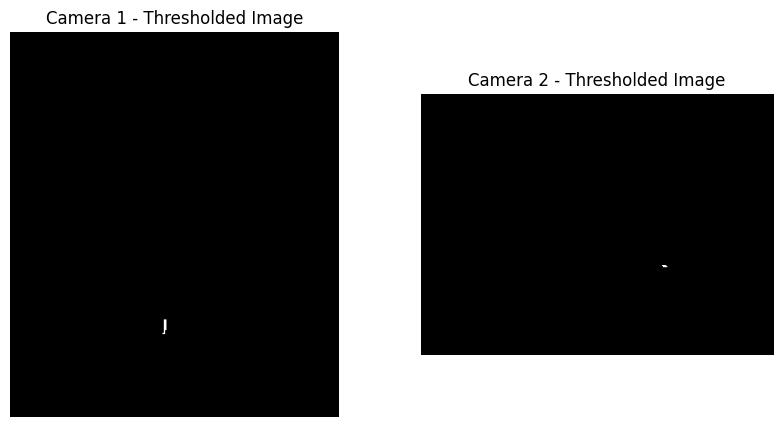

Unique values in Camera 1 thresholded image: [0. 1.]
Unique values in Camera 2 thresholded image: [0. 1.]


In [ ]:
def display_thresholded_image(index):
    _, image_1 = cv2.threshold(cam1_imgs[index], 0.1, 1.0, cv2.THRESH_BINARY)
    _, image_2 = cv2.threshold(cam2_imgs[index], 0.1, 1.0, cv2.THRESH_BINARY)
    # open and close to remove noise
    structure = np.ones((2,2))
    image_1 = ndi.binary_closing(image_1, structure=structure).astype(np.float32)
    image_2 = ndi.binary_closing(image_2, structure=structure).astype(np.float32)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Camera 1 - Thresholded Image")
    plt.imshow(image_1, cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title("Camera 2 - Thresholded Image")
    plt.imshow(image_2, cmap='gray')
    plt.axis('off')
    plt.show()
    print(f"Unique values in Camera 1 thresholded image: {np.unique(image_1)}")
    print(f"Unique values in Camera 2 thresholded image: {np.unique(image_2)}")

display_thresholded_image(120)

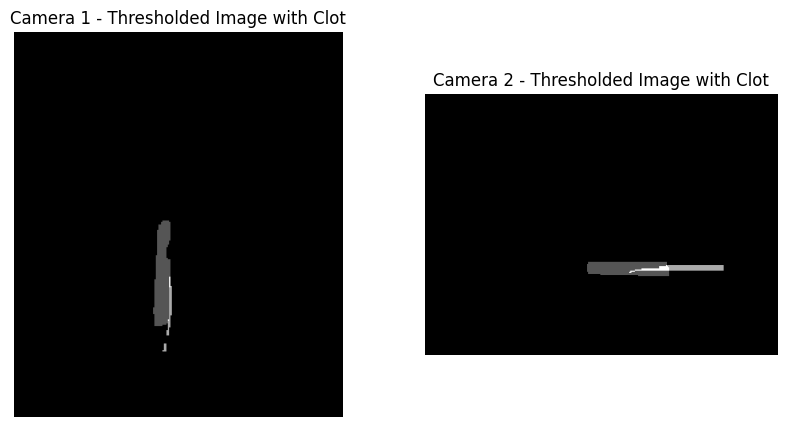

In [ ]:
def display_thresholded_image_with_clot(index):
    _, image_1 = cv2.threshold(cam1_imgs[index], 0.1, 1.0, cv2.THRESH_BINARY)
    _, image_2 = cv2.threshold(cam2_imgs[index], 0.1, 1.0, cv2.THRESH_BINARY)
    # open and close to remove noise
    structure = np.ones((100,100))
    image_1 = ndi.binary_closing(image_1, structure=structure).astype(np.float32)
    image_2 = ndi.binary_closing(image_2, structure=structure).astype(np.float32)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Camera 1 - Thresholded Image with Clot")
    plt.imshow(image_1 + 0.5*calib1_smoothed, cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title("Camera 2 - Thresholded Image with Clot")
    plt.imshow(image_2 + 0.5*calib2_smoothed, cmap='gray')
    plt.axis('off')
    plt.show()

display_thresholded_image_with_clot(190)

## Exponential moving average

In [16]:
# Preallocate arrays
cam1_imgs = np.stack([
    cv2.resize(cv2.imread(str(p), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0, (0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
    for p in cam1_paths
]).astype(np.float32)

cam2_imgs = np.stack([
    cv2.resize(cv2.imread(str(p), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0, (0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
    for p in cam2_paths
]).astype(np.float32)

ValueError: need at least one array to stack

In [ ]:
print(f"cam1_imgs shape: {cam1_imgs.shape}")
print(f"cam2_imgs shape: {cam2_imgs.shape}")

cam1_imgs shape: (365, 288, 246)
cam2_imgs shape: (365, 236, 318)


In [ ]:
alpha = 0.01 # update speed of background
threshold = 0.05

background_1 = cam1_imgs[0]
background_2 = cam2_imgs[0]
masks_1 = []
masks_2 = []

for i in range(cam1_imgs.shape[0]):

    # --- Compute foreground mask ---
    diff_1 = np.abs(cam1_imgs[i] - background_1)
    mask_1 = (diff_1 > threshold).astype(np.float32)
    diff_2 = np.abs(cam2_imgs[i] - background_2)
    mask_2 = (diff_2 > threshold).astype(np.float32)
    masks_2.append(mask_2)
    masks_1.append(mask_1)

    # --- Update background (EMA) ---
    background_1 = alpha * cam1_imgs[i] + (1 - alpha) * background_1
    background_2 = alpha * cam2_imgs[i] + (1 - alpha) * background_2

## define useful shapes

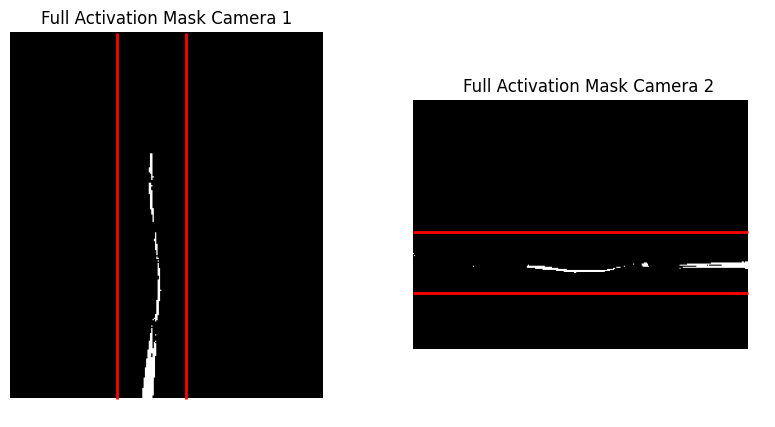

Full Activation Mask Camera 1 shape: (288, 246)
Full Activation Mask Camera 2 shape: (236, 318)


In [ ]:
# for each camera create an full_activation_mask which has true if any of the frame masks is true
full_activation_mask_1 = np.max(np.stack(masks_1), axis=0)
full_activation_mask_2 = np.max(np.stack(masks_2), axis=0)

# rotate first 90 and second 180 to get the right orientation
full_activation_mask_1 = np.rot90(full_activation_mask_1, k=1)
full_activation_mask_2 = np.rot90(full_activation_mask_2, k=2)

# create a safe margin around the activation masks
margin = 20
croped_full_activation_mask_1 = np.copy(full_activation_mask_1)
croped_full_activation_mask_2 = np.copy(full_activation_mask_2)
# find indices where full_activation_mask_1 is true
_, xs_1 = np.where(full_activation_mask_1 > 0)
ys_2, _ = np.where(full_activation_mask_2 > 0)
# find min and max indices
min_x_1 = max(np.min(xs_1) - margin, 0)
max_x_1 = min(np.max(xs_1) + margin, full_activation_mask_1.shape[1])
min_y_2 = max(np.min(ys_2) - margin, 0)
max_y_2 = min(np.max(ys_2) + margin, full_activation_mask_2.shape[0])
# plot full activation masks
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Full Activation Mask Camera 1")
plt.imshow(full_activation_mask_1, cmap='gray')
# plot vline
plt.vlines([min_x_1, max_x_1], 0, full_activation_mask_1.shape[0], colors='red', linewidth=2)
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Full Activation Mask Camera 2")
plt.imshow(full_activation_mask_2, cmap='gray')
# plot vline
plt.hlines([min_y_2, max_y_2], 0, full_activation_mask_2.shape[1], colors='red', linewidth=2)
plt.axis('off')
plt.show()
# print shapes of masks
print(f"Full Activation Mask Camera 1 shape: {full_activation_mask_1.shape}")
print(f"Full Activation Mask Camera 2 shape: {full_activation_mask_2.shape}")

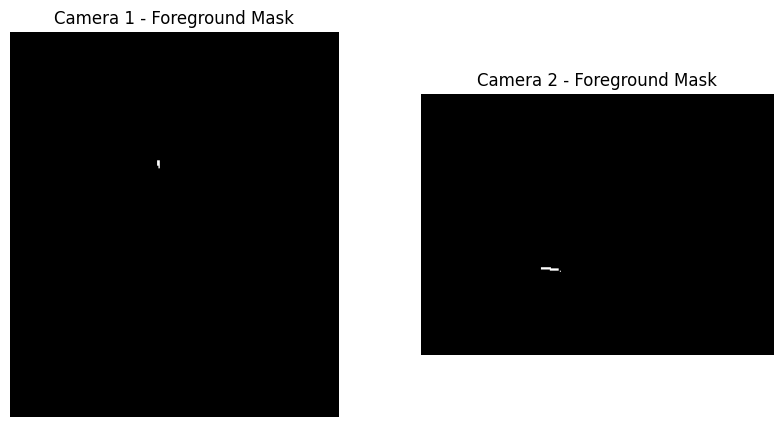

In [ ]:
# display mask at index
index = 364
_, image_1 = cv2.threshold(masks_1[index], 0.1, 1.0, cv2.THRESH_BINARY)
_, image_2 = cv2.threshold(masks_2[index], 0.1, 1.0, cv2.THRESH_BINARY)
# open and close to remove noise
structure = np.ones((20,20))
image_1 = ndi.binary_closing(image_1, structure=structure).astype(np.float32)
image_2 = ndi.binary_closing(image_2, structure=structure).astype(np.float32)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Camera 1 - Foreground Mask")
plt.imshow(image_1, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Camera 2 - Foreground Mask")
plt.imshow(image_2, cmap='gray')
plt.axis('off')
plt.show()

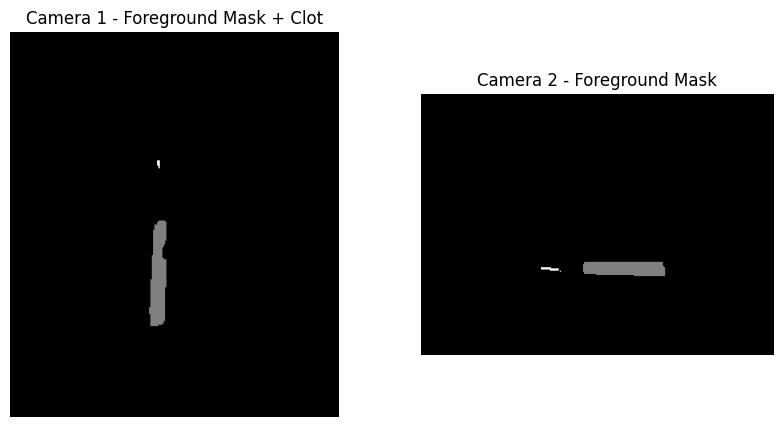

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Camera 1 - Foreground Mask + Clot")
plt.imshow(image_1 + 0.5 * calib1_smoothed, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Camera 2 - Foreground Mask")
plt.imshow(image_2 + 0.5 * calib2_smoothed, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
def count_blobs(image):
    labeled_array, num_features = ndi.label(image)
    return num_features

num_blobs_1 = count_blobs(image_1)
num_blobs_2 = count_blobs(image_2)
print(f"Number of blobs in Camera 1 image: {num_blobs_1}")
print(f"Number of blobs in Camera 2 image: {num_blobs_2}")

num_blobs_with_clot_1 = count_blobs(image_1 + 0.5 * calib1_smoothed)
num_blobs_with_clot_2 = count_blobs(image_2 + 0.5 * calib2_smoothed)
print(f"Number of blobs in Camera 1 image with clot: {num_blobs_with_clot_1}")
print(f"Number of blobs in Camera 2 image with clot: {num_blobs_with_clot_2}")

Number of blobs in Camera 1 image: 1
Number of blobs in Camera 2 image: 2
Number of blobs in Camera 1 image with clot: 2
Number of blobs in Camera 2 image with clot: 3


# Preprocessing

In [ ]:
from data.preprocess_data import preprocess_images
imgs_1, imgs_2 = preprocess_images(log_names.head(1), save=True)

Cropping and resizing masks: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


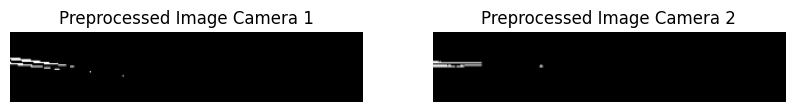

In [ ]:
index = 150
# plot imgs_1[index] and imgs_2[index]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Preprocessed Image Camera 1")
plt.imshow(imgs_1[0][index], cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Preprocessed Image Camera 2")
plt.imshow(imgs_2[0][index], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
from models.gru import MaskEncoder
import torch
mask_encoder = MaskEncoder().to('cpu')
# get encoded mask for imgs_1[0][index] and imgs_2[0][index]
mask_1 = mask_encoder(torch.tensor(imgs_1[0][index]).unsqueeze(0).unsqueeze(0).float())
mask_2 = mask_encoder(torch.tensor(imgs_2[0][index]).unsqueeze(0).unsqueeze(0).float())

In [ ]:
print(f"Encoded mask 1 shape: {mask_1.shape}")

Encoded mask 1 shape: torch.Size([1, 8])


In [ ]:
# Batch parameters
B = 4          # batch size
T = 10         # sequence length
feat_dim = 4  # input feature dimension
H, W = 60, 300 # mask dimensions

# Dummy feature input
x = torch.randn(B, T, feat_dim)

# Dummy masks (B, T, 2 channels, H, W)
mask = torch.randn(B, T, 2, H, W)

from models.gru import GRUClassifier
# Instantiate model with images enabled
model = GRUClassifier(
    input_size=feat_dim,
    hidden_size=32,
    num_layers=1,
    output_size=1,
    with_images=True
)

# Run forward pass
out, _= model(x, mask)

print("Output shape :", out.shape)  # expected (B, T, 1)

/home/boesch/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Output shape : torch.Size([4, 10, 1])


# Extra Data

## Anatomical

In [ ]:
heads_keep = ["timestamp [s]", "Force sensor voltage [V]", "Camera trigger signal"]
heads_rename = ["timestamps", "force_sensor_v", "camera_trigger_signal"]
f_s = 1000
fss = 568.5
log_names = ld.get_paper_logs()
log_names.reset_index(drop=True, inplace=True)
log = log_names.iloc[0]
cam1_paths, cam2_paths = ld.get_images_paths_from_log(log, processed=True)

/home/boesch/TREX-Semester-Project/data/processed/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward
[PosixPath('/home/boesch/TREX-Semester-Project/data/processed/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward/frameID_95image95_mask.npz'), PosixPath('/home/boesch/TREX-Semester-Project/data/processed/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward/frameID_19image19_mask.npz'), PosixPath('/home/boesch/TREX-Semester-Project/data/processed/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward/II_frameID_160image160_mask.npz'), PosixPath('/home/boesch/TREX-Semester-Project/data/processed/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward/II_frameID_196image196_mask.npz'), PosixPath('/home/boesch/TREX-Semester-Project/data/processed/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward/II_frameID_37image37_mask.npz'), PosixPath('/home/boesch/TREX-Semester-Project/data/processed/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward/frameID_311image311_mask.npz

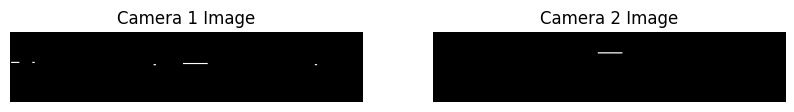

In [ ]:
# load and plot images at given index for both cameras
import cv2
index = 300
# images are stored as npz files, load them
data_1 = np.load(str(cam1_paths[index]))['mask']
data_2 = np.load(str(cam2_paths[index]))['mask']
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Camera 1 Image")
# show the images with matplotlib
plt.imshow(data_1, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Camera 2 Image")
plt.imshow(data_2, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
def EMA(cam1_paths, cam2_paths):
    # Preallocate arrays
    cam1_imgs = np.stack([
        cv2.resize(cv2.imread(str(p), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0, (0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
        for p in cam1_paths
    ]).astype(np.float32)

    cam2_imgs = np.stack([
        cv2.resize(cv2.imread(str(p), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0, (0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
        for p in cam2_paths
    ]).astype(np.float32)
    print(f"cam1_imgs shape: {cam1_imgs.shape}")
    print(f"cam2_imgs shape: {cam2_imgs.shape}")
    alpha = 0.2 # update speed of background
    threshold = 0.05

    background_1 = cam1_imgs[0]
    background_2 = cam2_imgs[0]
    masks_1 = []
    masks_2 = []

    for i in range(cam1_imgs.shape[0]):

        # --- Compute foreground mask ---
        diff_1 = np.abs(cam1_imgs[i] - background_1)
        mask_1 = (diff_1 > threshold).astype(np.float32)
        diff_2 = np.abs(cam2_imgs[i] - background_2)
        mask_2 = (diff_2 > threshold).astype(np.float32)
        masks_2.append(mask_2)
        masks_1.append(mask_1)

        # --- Update background (EMA) ---
        background_1 = alpha * cam1_imgs[i] + (1 - alpha) * background_1
        background_2 = alpha * cam2_imgs[i] + (1 - alpha) * background_2
        # for each camera create an full_activation_mask which has true if any of the frame masks is true
        
    full_activation_mask_1 = np.max(np.stack(masks_1), axis=0)
    full_activation_mask_2 = np.max(np.stack(masks_2), axis=0)

    # create a safe margin around the activation masks
    margin = 20
    croped_full_activation_mask_1 = np.copy(full_activation_mask_1)
    croped_full_activation_mask_2 = np.copy(full_activation_mask_2)
    # find indices where full_activation_mask_1 is true
    _, xs_1 = np.where(full_activation_mask_1 > 0)
    ys_2, _ = np.where(full_activation_mask_2 > 0)
    # find min and max indices
    min_x_1 = max(np.min(xs_1) - margin, 0)
    max_x_1 = min(np.max(xs_1) + margin, full_activation_mask_1.shape[1])
    min_y_2 = max(np.min(ys_2) - margin, 0)
    max_y_2 = min(np.max(ys_2) + margin, full_activation_mask_2.shape[0])
    # plot full activation masks
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Full Activation Mask Camera 1")
    plt.imshow(full_activation_mask_1, cmap='gray')
    # plot vline
    plt.vlines([min_x_1, max_x_1], 0, full_activation_mask_1.shape[0], colors='red', linewidth=2)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title("Full Activation Mask Camera 2")
    plt.imshow(full_activation_mask_2, cmap='gray')
    # plot vline
    plt.hlines([min_y_2, max_y_2], 0, full_activation_mask_2.shape[1], colors='red', linewidth=2)
    plt.axis('off')
    plt.show()
    # print shapes of masks
    print(f"Full Activation Mask Camera 1 shape: {full_activation_mask_1.shape}")
    print(f"Full Activation Mask Camera 2 shape: {full_activation_mask_2.shape}")

In [ ]:
cam1_paths, cam2_paths = ld.get_images_paths_from_log(log, processed=False)

UnidentifiedImageError: cannot identify image file '/home/boesch/TREX-Semester-Project/data/processed/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward/frameID_201image201_mask.npz'

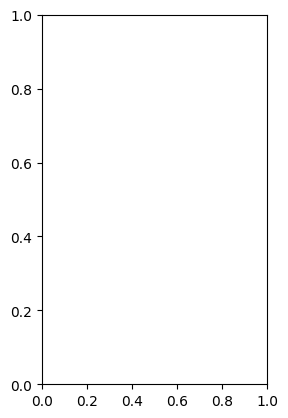

In [ ]:
# plot images from both cam at index
index = 201
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(cam1_paths[index]))

plt.subplot(1, 2, 2)
plt.imshow(plt.imread(cam2_paths[index]))

In [ ]:
from data.preprocess_data import preprocess_images
imgs_1, imgs_2 = preprocess_images(log_names.head(1), save=True, delete=False)

Preprocessing images:   0%|          | 0/1 [00:00<?, ?it/s]

Processing the images of log 1/1: /home/boesch/TREX-Semester-Project/data/raw/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward/log_2022-06-30_15-38-36.csv


Cropping and resizing masks: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


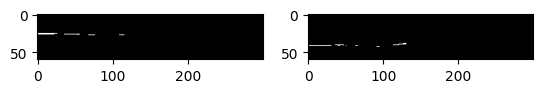

In [ ]:
# plot images at index
index = 200
plt.subplot(1, 2, 1)
plt.imshow(imgs_1[0][index], cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(imgs_2[0][index], cmap='gray')

/home/boesch/TREX-Semester-Project/data/processed/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward
[PosixPath('/home/boesch/TREX-Semester-Project/data/processed/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward/frameID_95image95_mask.npz'), PosixPath('/home/boesch/TREX-Semester-Project/data/processed/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward/frameID_19image19_mask.npz'), PosixPath('/home/boesch/TREX-Semester-Project/data/processed/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward/II_frameID_160image160_mask.npz'), PosixPath('/home/boesch/TREX-Semester-Project/data/processed/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward/II_frameID_196image196_mask.npz'), PosixPath('/home/boesch/TREX-Semester-Project/data/processed/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward/II_frameID_37image37_mask.npz'), PosixPath('/home/boesch/TREX-Semester-Project/data/processed/Paper_experiments/Experiments_2022_06_30/Clot 1/Forward/frameID_311image311_mask.npz

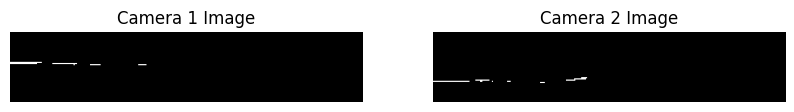

In [ ]:
cam1_paths, cam2_paths = ld.get_images_paths_from_log(log, processed=True)
# load and plot images at given index for both cameras
import cv2
# images are stored as npz files, load them
data_1 = np.load(str(cam1_paths[index]))['mask']
data_2 = np.load(str(cam2_paths[index]))['mask']
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Camera 1 Image")
# show the images with matplotlib
plt.imshow(data_1, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Camera 2 Image")
plt.imshow(data_2, cmap='gray')
plt.axis('off')
plt.show()